
import pyLDAvis
import pyLDAvis.sklearn
# Space Experience Review Analysis

In [1]:
import pandas as pd
import pdfplumber
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

In [2]:
def pdf_to_csv(pdf_path, csv_path):
    # Initialize a list to hold the extracted data
    data = []

    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            # Extract text from the page
            text = page.extract_text()
            if text:
                # Split the text into sentences using '.' as the delimiter
                sentences = text.split('.')
                for sentence in sentences:
                    # Strip leading/trailing whitespace and add to data if not empty
                    cleaned_sentence = sentence.strip()
                    if cleaned_sentence:
                        data.append(cleaned_sentence)

    # Create a DataFrame with two columns: 'slno' and 'reviews'
    df = pd.DataFrame({
        'slno': range(1, len(data) + 1),
        'reviews': data
    })

    # Write the DataFrame to a CSV file
    df.to_csv(csv_path, index=False)

# Example usage
pdf_path = 'SpacePDF.pdf'
csv_path = 'spacereviews.csv'
pdf_to_csv(pdf_path, csv_path)


In [3]:
df = pd.read_csv('spacereviews.csv')

In [4]:
df.head()

,slno,reviews
0,1,Space Tourism\nDennis M
1,2,"Bushnell\nIntroduction\nSince the late 1950’s,..."
2,3,"Going forward, there is an increasing expectat..."
3,4,With the ever\nincreasing capabilities of what...
4,5,Both\nwill be discussed herein (ref


In [5]:
def clean_text(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove special characters (keep only letters and spaces)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Remove words with less than 3 letters
    text = ' '.join([word for word in text.split() if len(word) > 2])
    return text

In [6]:
def remove_wikipedia_and_commas(text):
    # Remove the word 'wikipedia'
    text = re.sub(r'\bwikipedia\b', '', text, flags=re.IGNORECASE)
    # Remove commas (although initial clean should remove it, this is just in case)
    text = text.replace(',', '')
    return text

In [7]:
# Apply the initial cleaning function to the 'reviews' column
df['initial_cleaned_reviews'] = df['reviews'].apply(clean_text)

In [8]:
# Apply the additional cleaning function to the initially cleaned reviews
df['final_cleaned_reviews'] = df['initial_cleaned_reviews'].apply(remove_wikipedia_and_commas)


In [9]:
# Remove rows with empty reviews
data = df[df['final_cleaned_reviews'].str.strip() != '']

In [10]:
# Reset the index to update the serial numbers
data = data.reset_index(drop=True)
data.index = data.index + 1
data.index.name = 'slno'

In [11]:
# Drop the intermediate 'initial_cleaned_reviews' column if no longer needed
df = df.drop(columns=['reviews', 'initial_cleaned_reviews'])

In [12]:
# Save the cleaned data to a new CSV file
df.to_csv('final_cleaned_reviews.csv', index=False)

In [13]:
df.head()

,slno,final_cleaned_reviews
0,1,Space Tourism Dennis
1,2,Bushnell Introduction Since the late humans sp...
2,3,Going forward there increasing expectation tha...
3,4,With the ever increasing capabilities what now...
4,5,Both will discussed herein ref


# Removing Stopwords using NLP

In [14]:
# Function to remove stop words
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [15]:
# Apply stop words removal to the 'final_cleaned_reviews' column
df['cleaned_reviews'] = df['final_cleaned_reviews'].apply(remove_stopwords)

In [16]:
df.head()

,slno,final_cleaned_reviews,cleaned_reviews
0,1,Space Tourism Dennis,Space Tourism Dennis
1,2,Bushnell Introduction Since the late humans sp...,Bushnell Introduction Since late humans space ...
2,3,Going forward there increasing expectation tha...,Going forward increasing expectation technolog...
3,4,With the ever increasing capabilities what now...,ever increasing capabilities termed digital re...
4,5,Both will discussed herein ref,discussed herein ref


## SentimentalAnalysis

### Step 1: Enhanced Sentiment Analysis Function

In [17]:
# Sentiment analysis function
def analyze_sentiment(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    compound_score = sentiment['compound']
    
    # Classify sentiment based on compound score
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

In [18]:
# Apply sentiment analysis to the 'cleaned_reviews' column
df['sentiment'] = df['cleaned_reviews'].apply(analyze_sentiment)

In [19]:
# Display the sentiment analysis results
print(df[['final_cleaned_reviews', 'sentiment']])

                                 final_cleaned_reviews sentiment
0                                 Space Tourism Dennis   Neutral
1    Bushnell Introduction Since the late humans sp...  Negative
2    Going forward there increasing expectation tha...   Neutral
3    With the ever increasing capabilities what now...   Neutral
4                       Both will discussed herein ref   Neutral
..                                                 ...       ...
266                                   and Moses Robert   Neutral
267  Commercial Space The Age New Space Reusable Ro...   Neutral
268                                    Bushnell Dennis   Neutral
269                                   and Moses Robert   Neutral
270  Prospectives Deep Space Infrastructures Develo...   Neutral

[271 rows x 2 columns]


### Step 2: Calculate Percentage of Positive and Negative Reviews

In [20]:
# Calculate percentage of positive and negative reviews
sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100
positive_percent = sentiment_counts.get('Positive', 0)
negative_percent = sentiment_counts.get('Negative', 0)

print(f"Percentage of Positive Reviews: {positive_percent:.2f}%")
print(f"Percentage of Negative Reviews: {negative_percent:.2f}%")

Percentage of Positive Reviews: 27.68%
Percentage of Negative Reviews: 11.81%


### Step 3: Visualize Sentiment Distribution

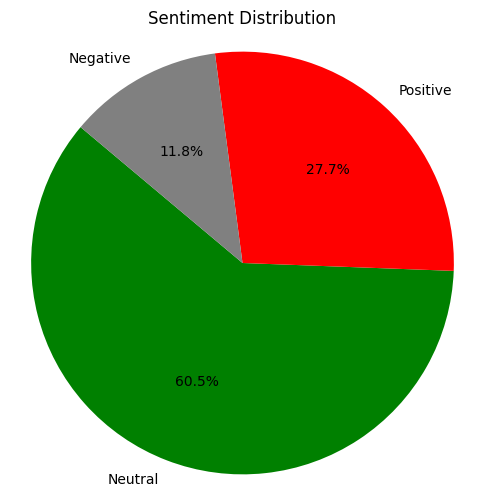

In [21]:
# Visualize sentiment distribution
labels = sentiment_counts.index
sizes = sentiment_counts.values

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['green', 'red', 'grey'])
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.show()

# TF-IDF Analysis

### Step 1: Initialize and Fit TF-IDF Vectorizer

In [22]:
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

In [23]:
# Fit and transform the 'cleaned_reviews' column
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_reviews'])

In [24]:
# Get feature names
tfidf_features = tfidf_vectorizer.get_feature_names_out()

In [25]:
# Display TF-IDF matrix 
print(tfidf_matrix.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [26]:
# Calculate TF-IDF scores for each document
tfidf_scores_per_document = []
for i, doc in enumerate(df['cleaned_reviews']):
    feature_index = tfidf_matrix[i,:].nonzero()[1]
    tfidf_scores = zip(feature_index, [tfidf_matrix[i, x] for x in feature_index])
    scores = {tfidf_features[i]: score for i, score in tfidf_scores}
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    tfidf_scores_per_document.append(sorted_scores)

In [27]:
# Print TF-IDF scores for each document
for i, scores in enumerate(tfidf_scores_per_document):
    print(f"Document {i+1}:")
    for term, score in scores[:5]:  # Top 5 terms by TF-IDF score
        print(f"{term}: {score:.4f}")
    print()

Document 1:
dennis: 0.7991
tourism: 0.5064
space: 0.3240

Document 2:
restricted: 0.3152
defined: 0.3152
late: 0.3152
introduction: 0.3152
astronauts: 0.2782

Document 3:
vacation: 0.3975
visit: 0.3767
forward: 0.3606
going: 0.3475
public: 0.3363

Document 4:
vacations: 0.3632
termed: 0.3383
approaches: 0.3206
capabilities: 0.3206
immersive: 0.3069

Document 5:
discussed: 0.7716
ref: 0.6361

Document 6:

Document 7:
stations: 0.3792
moons: 0.3594
include: 0.3315
experiences: 0.3315
planets: 0.3209

Document 8:
stars: 0.4059
known: 0.4059
virtually: 0.4059
planetsmoons: 0.3780
currently: 0.3780

Document 9:
tourism: 0.4310
space: 0.3677
resultant: 0.2785
addressing: 0.2785
addressis: 0.2785

Document 10:
species: 0.2510
trace: 0.2510
matter: 0.2510
solid: 0.2510
unimaginable: 0.2510

Document 11:
different: 0.3818
referred: 0.3818
stated: 0.3556
environmental: 0.3556
general: 0.3556

Document 12:
considerable: 0.5323
required: 0.4498
technology: 0.4195
humans: 0.3969
enable: 0.3874

Doc

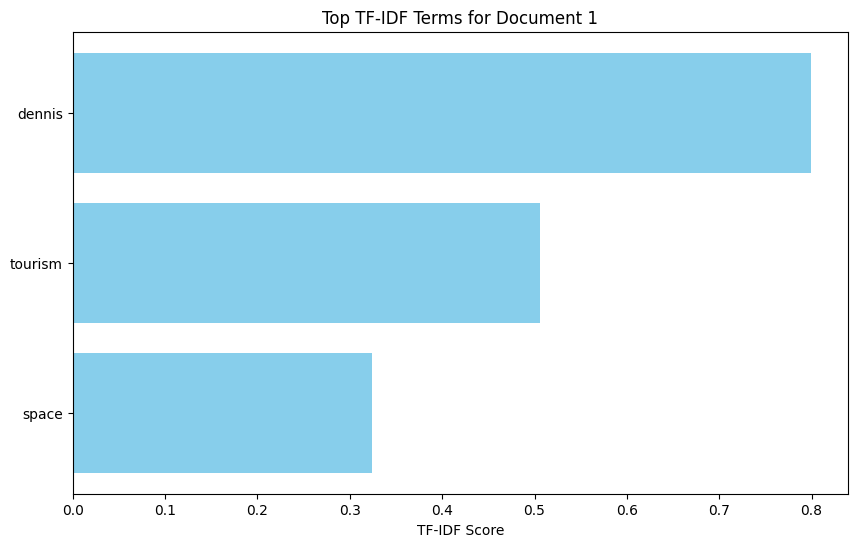

In [28]:
# Optional: Visualize TF-IDF scores for a specific document (e.g., document 1)
doc_idx = 0  # Adjust the index as needed
top_terms = [term for term, score in tfidf_scores_per_document[doc_idx][:10]]
scores = [score for term, score in tfidf_scores_per_document[doc_idx][:10]]

plt.figure(figsize=(10, 6))
plt.barh(top_terms, scores, color='skyblue')
plt.xlabel('TF-IDF Score')
plt.title(f'Top TF-IDF Terms for Document {doc_idx + 1}')
plt.gca().invert_yaxis()
plt.show()

 ### Step 3: Visualizing TF-IDF with Word Clouds

In [29]:
# Get TF-IDF scores for each term
tfidf_scores = tfidf_matrix.sum(axis=0).A1
indices = tfidf_scores.argsort()[::-1]
top_tfidf_features = [tfidf_features[i] for i in indices[:20]]
top_tfidf_scores = tfidf_scores[indices][:20]

In [30]:
# Create a dictionary of word and tfidf score
word_tfidf_dict = {word: score for word, score in zip(top_tfidf_features, top_tfidf_scores)}

In [31]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_tfidf_dict)

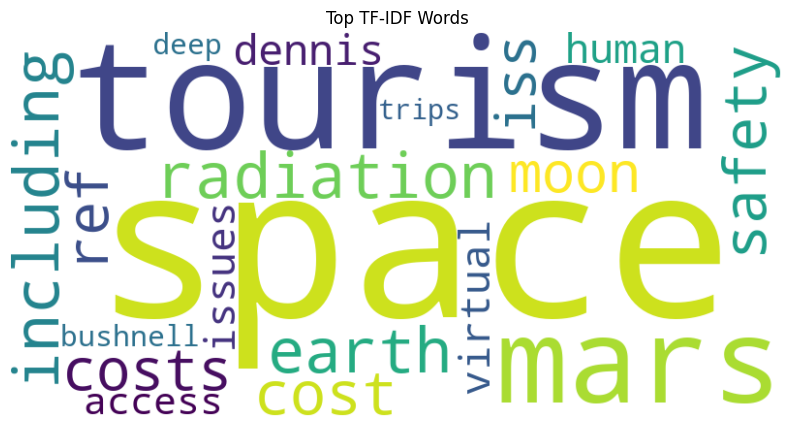

In [32]:
# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top TF-IDF Words')
plt.show()

### Visualizing TF-IDF with Bar Graphs

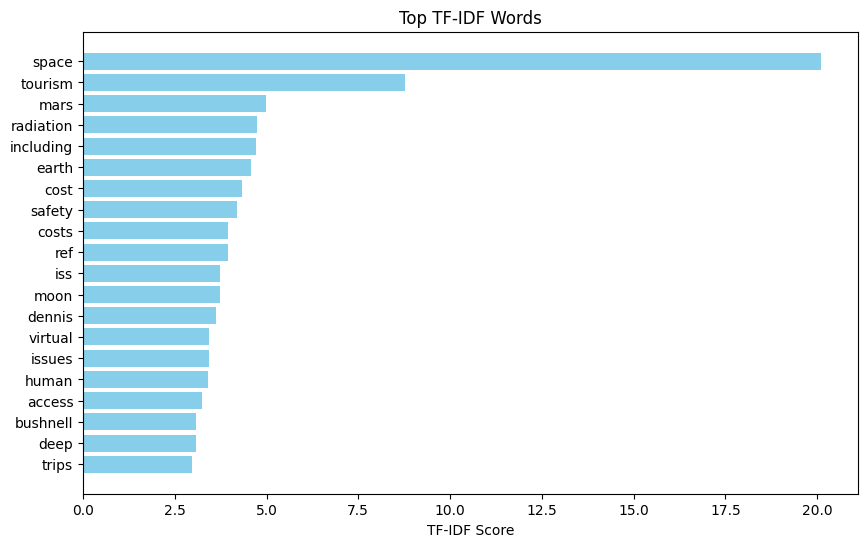

In [33]:
# Plot bar graph for top TF-IDF scores
plt.figure(figsize=(10, 6))
plt.barh(top_tfidf_features, top_tfidf_scores, align='center', color='skyblue')
plt.xlabel('TF-IDF Score')
plt.title('Top TF-IDF Words')
plt.gca().invert_yaxis()
plt.show()

# Topic Modeling (LDA)

### Step 1: Initialize and Fit LDA Model

In [34]:
# Initialize LDA model
n_topics = 8  # Number of topics
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)

In [35]:
    # Fit LDA model to the TF-IDF matrix
    lda_model.fit(tfidf_matrix)

LatentDirichletAllocation(n_components=8, random_state=42)

In [ ]:

# LDA Visualization with pyLDAvis
lda_display = pyLDAvis.sklearn.prepare(lda_model, count_matrix, count_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)


### Step 2: Display Topics and Top Words

In [36]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

no_top_words = 5  # Number of top words to display for each topic
display_topics(lda_model, tfidf_features, no_top_words)

Topic 1:
space radiation protection planets tourism

Topic 2:
space micro transits fast radiation

Topic 3:
space tourism safety commercial earth

Topic 4:
space dennis bushnell earth order

Topic 5:
space tourism ref issues discussed

Topic 6:
mars space cost human trips

Topic 7:
moses robert transportation probably radiation

Topic 8:
space colonization deep tourism time



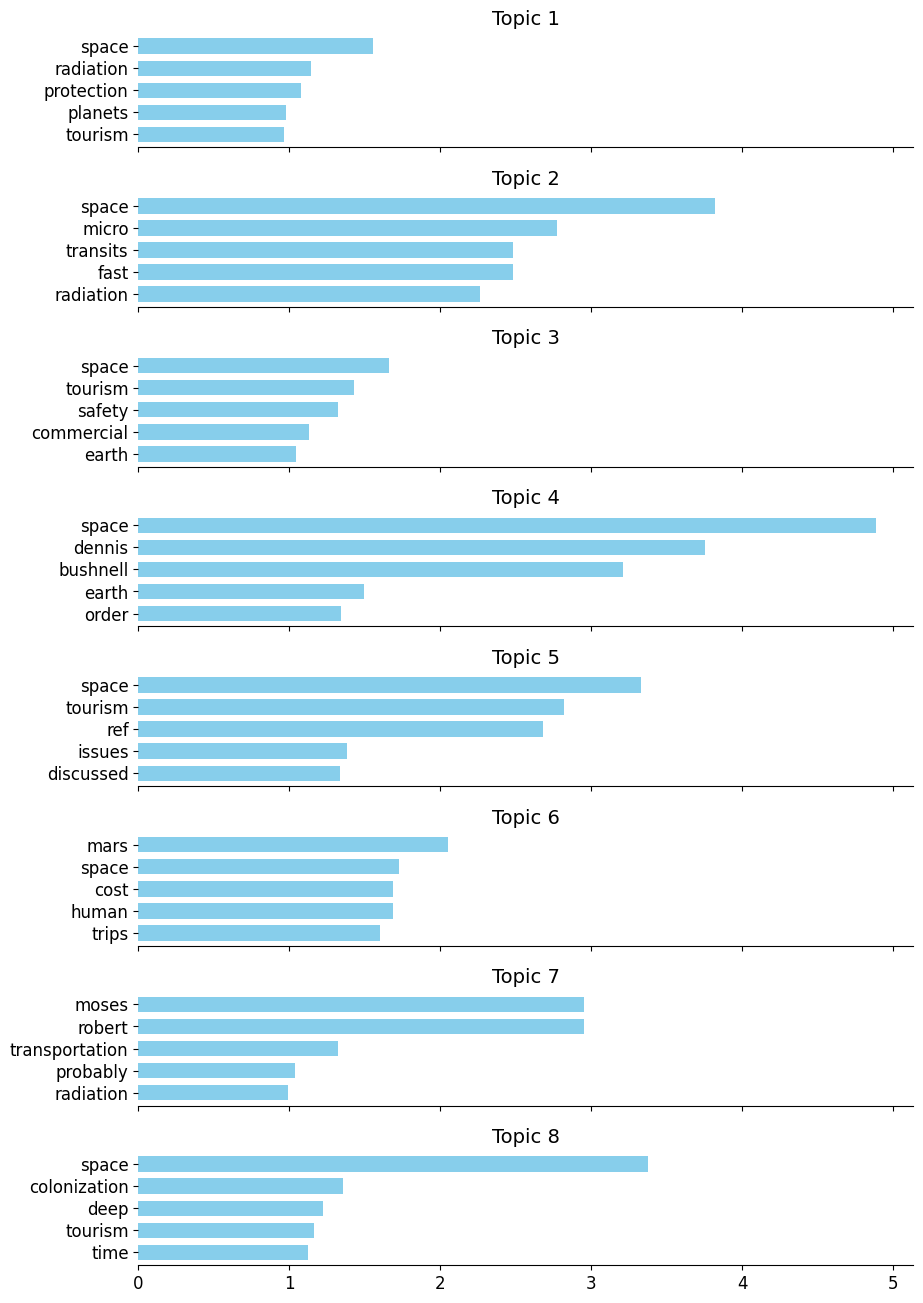

In [37]:
# Function to visualize topics
def visualize_topics(model, feature_names, no_top_words):
    fig, axes = plt.subplots(n_topics, 1, figsize=(10, 16), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color='skyblue')
        ax.set_title(f'Topic {topic_idx + 1}', fontsize=14)
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.subplots_adjust(hspace=0.4)
        
    plt.show()

# Visualize topics with top words
visualize_topics(lda_model, tfidf_features, no_top_words)


# Word Clouds and Visualization

In [38]:
# Generate word cloud for all documents
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleaned_reviews']))

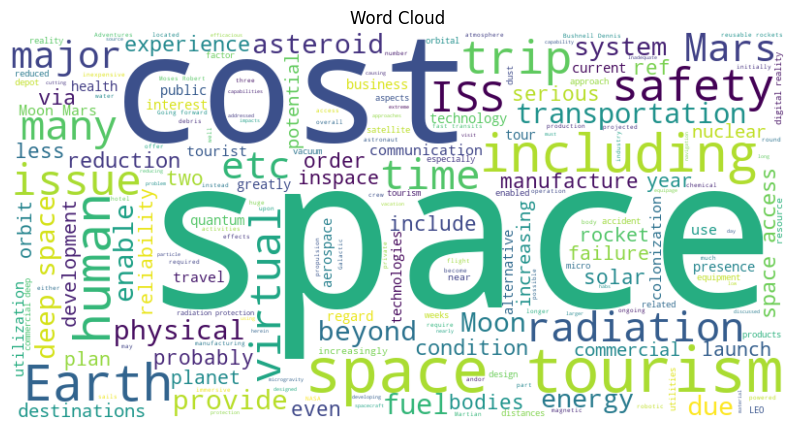

In [39]:
# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

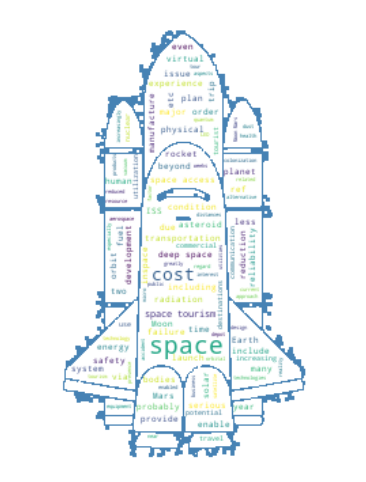

In [40]:
# Load the space rocket image and create a mask
rocket_mask = np.array(Image.open('r1.png'))

# Create a word cloud
wordcloud = WordCloud(
    background_color='white',
    max_words=1000,
    mask=rocket_mask,
    contour_width=1,
    contour_color='steelblue',
    stopwords=STOPWORDS
).generate(' '.join(df['cleaned_reviews']))

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


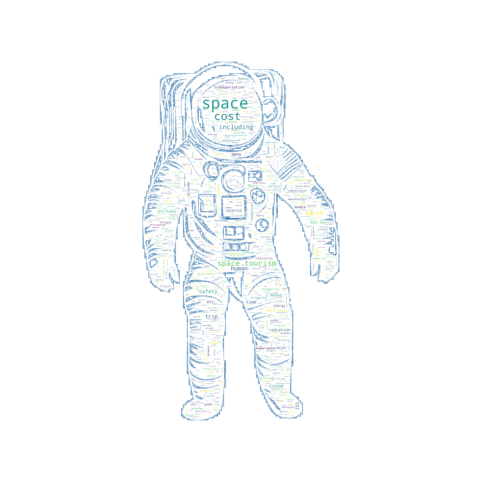

In [41]:
# Load the space rocket image and create a mask
rocket_mask = np.array(Image.open('austro.png'))

# Create a word cloud
wordcloud = WordCloud(
    background_color='white',
    max_words=1000,
    mask=rocket_mask,
    contour_width=1,
    contour_color='steelblue',
    stopwords=STOPWORDS
).generate(' '.join(df['cleaned_reviews']))

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


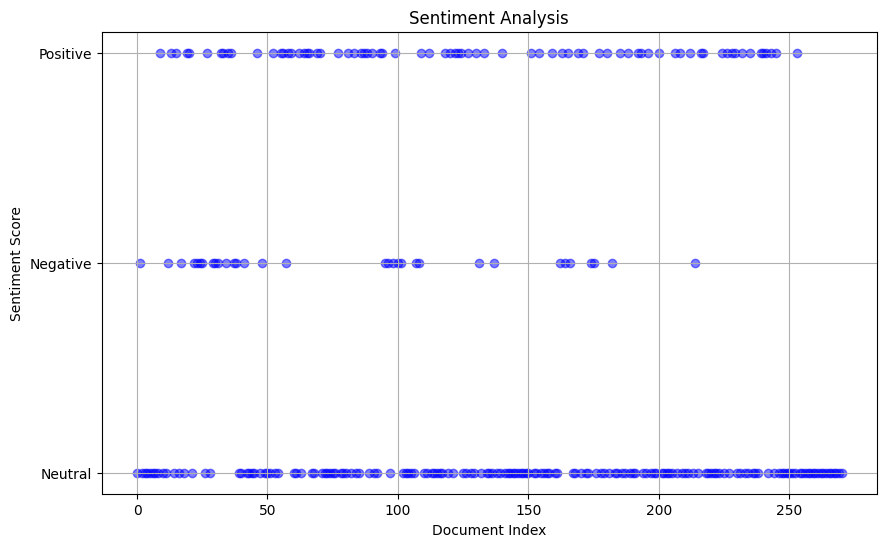

In [42]:
# Example visualization (e.g., sentiment vs. document index)
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['sentiment'], color='b', marker='o', alpha=0.5)
plt.title('Sentiment Analysis')
plt.xlabel('Document Index')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.show()